In [212]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [253]:
def gen_rand_vecs(dims, number):
    vecs1 = np.random.uniform(low=-1, high=1, size=(number,dims))
    vecs2= np.random.uniform(low=-1, high=1, size=(number,dims))
    mags1 = np.sqrt((vecs1*vecs1).sum(axis=-1))
    mags2 = np.sqrt((vecs2*vecs2).sum(axis=-1))
    vecs1 /= mags1[..., np.newaxis]
    vecs2 /= mags2[..., np.newaxis]
    angles = np.arccos((vecs1*vecs2).sum(axis=-1))
    return vecs1,vecs2,angles

1.4239003998072552


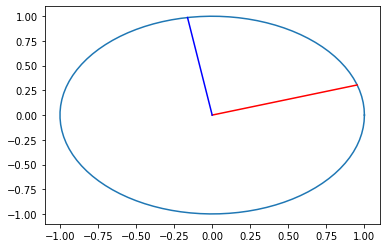

In [254]:
number = 1
theta = np.linspace(0, 2*np.pi, 100)
circle = np.array([np.cos(theta), np.sin(theta)])

fig = plt.figure()
plt.plot(circle[0], circle[1])
e1,e2,angles = gen_rand_vecs(2, number)
for i in range(number):
    print(angles[i])
    plt.plot([0,e1[i][0]], [0,e1[i][1]], 'r')
    plt.plot([0,e2[i][0]], [0,e2[i][1]], 'b')
plt.show()


bingham distribution uncertainty modelling in SO2
- The element of the distribution should be element of the group 

$p(x;M,Z) = N(MZM^T)^{-1}exp(xMZM^Tx^T)$ where x $\in$ SO2

Idea 1 : Orthogonal vectors M on x in $R^2$ is 0,1 1,0 ; do not know how to calculate Z (eigen values, so can be 1,1)
Since the M and Z are in the vector space of SO2 one cannot use this

Idea 2: Calculate coviariance matrix $XX^T$ and use eigen vector and eigen values to calculate M and Z 
The dimension of X is 1 so there is no covariance and that $XX^T$ provides a scalar and can be modelled by gaussian distribution

Idea 3: Train neural network to estimate M and Z by caluclating the maximum likelihood of these parameters using bingham loss.


Idea 4: The vector space for SO2 would be x + iy with the map of $e^{ik\theta}$ M can [1,i],[1,-i]

Log Bingham Loss : $L(y,M,Z) = - log(p(y;M,Z) = - yMZM^Ty^T + log N(Z)$

In [135]:
n = 100
v1,v2,a = gen_rand_vecs(2, n)
a_reshape = a.reshape(n,1)

#mean of the observations
x_mean = np.mean(a)

x_mean_arr = np.full((n,1),x_mean)

x_mean_arr.shape

x_ = np.subtract(a_reshape,x_mean_arr)

x_square = np.multiply(x_,x_)

x_sum = np.sum(x_square)

x_std = x_sum/(n-1)

In [136]:
x_std

0.7380830786307565

In [137]:
prob_density = lambda x : (np.pi*x_std) * np.exp(-0.5*((x - x_mean)/x_std)**2)

_,_,a_t = gen_rand_vecs(2, n)

In [138]:
a_sort = np.sort(a_t)

In [139]:
a_sort

array([0.01312577, 0.0437628 , 0.06015735, 0.07627024, 0.07951637,
       0.08441873, 0.14283205, 0.19084906, 0.30317292, 0.30409135,
       0.37995923, 0.3835775 , 0.45506189, 0.48736766, 0.50819173,
       0.55927781, 0.64711224, 0.67098634, 0.69091188, 0.69233837,
       0.70174528, 0.76440313, 0.76721712, 0.77526785, 0.77677625,
       0.78636066, 0.7979159 , 0.81141802, 0.88979564, 0.9190866 ,
       0.97645544, 1.01634998, 1.03395844, 1.09951472, 1.10717866,
       1.11623213, 1.18948558, 1.19820516, 1.2863664 , 1.2910286 ,
       1.29247354, 1.32254054, 1.36855416, 1.43946967, 1.44978602,
       1.45778006, 1.47215918, 1.49856865, 1.54428112, 1.54828478,
       1.59554423, 1.63879377, 1.63890171, 1.66092744, 1.67373   ,
       1.67557592, 1.72916649, 1.73437432, 1.75567063, 1.78907741,
       1.86898417, 1.93832368, 2.02502706, 2.03154161, 2.04302186,
       2.09513593, 2.12486261, 2.16902111, 2.17592837, 2.26807525,
       2.28690539, 2.31296575, 2.33377087, 2.36116965, 2.36798

Text(0, 0.5, 'Probability Density')

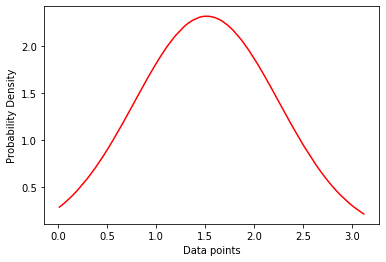

In [140]:
pdf = prob_density(a_sort)

plt.plot(a_sort,pdf , color = 'red')
plt.xlabel('Data points')
plt.ylabel('Probability Density')

In [216]:
import torch
import tensorflow as tf

In [217]:
import torch.optim as optim

In [218]:
lin = torch.nn.Linear(2,6)

In [219]:
def convert_to_vector_space_IUR(theta):
    out = np.empty(theta.shape + (2,))

    ct = np.cos(theta)
    st = np.sin(theta)
    out[..., 0] = ct
    out[..., 1] = st
    return out

In [224]:
def _log_bingham_loss(target, M, Z):
    r"""Log Bingham likelihood loss.

    The Bingham distribution is parametrized as

    f(x) = N(Z) * exp(x^T MZM^Tx)

    with x being defined on the hypershere, i.e. ||x||=1.

    Note: This has been developed using CPU-only storage of Tensors and may
     require adaptation when used with GPU.

    Parameters:
        target: Target values at which the likelihood is evaluated of shape
            (N, 4).
        M: Bingham distribution location and axes parameter of shape
            (N,4,4). M is expected to be an orthonormal matrix.
        Z: Tensor representing the Z parameter matrix of shape (N, 3).
            The parameters are expected to be negative and given in an
            ascending order.
        rbf: RBF object
    Returns:
        log likelihood: log value of the pdf for each of the target samples.
    """

#     assert target.dim() == 2 and target.shape[1] == 4, \
#         "Wrong dimensionality of target tensor."

#     assert M.dim() == 3 and M.shape[1:3] == (4, 4), \
#         "Wrong dimensionality of location parameter matrix M."

#     assert Z.dim() == 2 and Z.shape[1] == 3, \
#         "Wrong dimensionality of location parameter matrix Z."

#     assert Z.shape[0] == M.shape[0] and Z.shape[0] == target.shape[0], \
#         "Number of samples does not agree with number of parameters."

    if target.is_cuda:
        device = target.get_device()
    else:
        device = "cpu"

    # Adds missing 0 to vectors Z and turns them into diagonal matrices.
#     z_padded = torch.cat(
#         (Z, torch.zeros((Z.shape[0], 1), device=device, dtype=M.dtype)),
#         dim=1)
    z_as_matrices = torch.diag_embed(Z)

#     norm_const = BinghamInterpolationRBF.apply(Z, rbf)
    likelihoods = torch.bmm(torch.bmm(torch.bmm(torch.bmm(
            target.unsqueeze(1),
            M),
            z_as_matrices),
            M.transpose(1, 2)),
            target.unsqueeze(2)).squeeze()
    return likelihoods

In [225]:
def loss_network(target, output):
        if target.is_cuda:
            device = target.get_device()
        M, Z = _output_to_m_z(output)
        log_likelihood = torch.sum(_log_bingham_loss(
                    target, M, Z))

        loss = -log_likelihood
        return loss, log_likelihood / target.shape[0]

In [226]:
def _output_to_m_z(output):
#     print(output.shape)
    batch_size = output.shape[0]
    m = output[:,:4]
    reshaped_output = m.reshape(batch_size, 2, 2)
    bd_m = gram_schmidt_batched(reshaped_output)
    z = -torch.exp(output[:,4:]).cumsum(1)[:, [1, 0]]
    return bd_m,z 


In [42]:
def gram_schmidt_batched(input_mat, reverse=False, modified=False):
    """ Carries out the Gram-Schmidt orthogonalization of a matrix on an
        entire batch.

    Arguments:
        input_mat (torch.Tensor): A tensor containing quadratic matrices each of
            which will be orthogonalized of shape (batch_size, m, m).
        reverse (bool): Starts gram Schmidt method beginning from the last
            column if set to True.
        modified (bool): Uses modified Gram-Schmidt as described.

    Returns:
        Q (torch.Tensor): A batch of orthogonal matrices of same shape as
            input_mat.
    """
    batch_size = input_mat.shape[0]
    mat_size = input_mat.shape[1]
    Q = torch.zeros(batch_size, mat_size, mat_size,
                    device=input_mat.device, dtype=input_mat.dtype)

    if modified:
    #TODO implement batched version
        for i in range(input_mat.shape[0]):
            q = gram_schmidt(input_mat[i], reverse, modified)
            Q[i] = q 
    elif not modified:
        if reverse:
            raise NotImplementedError
        else:
            outer_iterator = range(mat_size)
            def inner_iterator(k): return range(k)

        for j in outer_iterator:
            v = input_mat[:, :, j].view(batch_size, mat_size, 1)
            for i in inner_iterator(j):
                q_squeezed = Q[:, :, i].view(batch_size, 1, mat_size).clone()
                dot_products = torch.bmm(q_squeezed, v)
                p = dot_products.repeat((1, mat_size, 1)) \
                    * Q[:, :, i].unsqueeze(2).clone()
                v = v - p

            Q[:, :, j] = v.squeeze() / torch.norm(v, dim=1).repeat(1, mat_size)

    return Q

In [223]:
optimizer = optim.Adam(lin.parameters(), lr=0.001)

In [247]:
n = 100
losses = []
for i in range(1000):
    v1,v2,angles = gen_rand_vecs(2, n)
    preprocessing = convert_to_vector_space_IUR(angles)
    tensor = torch.tensor(preprocessing,dtype=torch.float32)
    output = lin(tensor)
    M, Z = _output_to_m_z(output)
    loss,likelihood = loss_network(tensor,output)
    losses.append(loss.item())
    print('[%d] loss: %.3f' %
                      (i + 1, loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print('Finished Training Trainset')

torch.Size([100, 2, 2])
[1] loss: 113.405
torch.Size([100, 2, 2])
[2] loss: 105.675
torch.Size([100, 2, 2])
[3] loss: 109.439
torch.Size([100, 2, 2])
[4] loss: 109.854
torch.Size([100, 2, 2])
[5] loss: 110.353
torch.Size([100, 2, 2])
[6] loss: 111.609
torch.Size([100, 2, 2])
[7] loss: 115.316
torch.Size([100, 2, 2])
[8] loss: 109.332
torch.Size([100, 2, 2])
[9] loss: 106.423
torch.Size([100, 2, 2])
[10] loss: 106.710
torch.Size([100, 2, 2])
[11] loss: 109.143
torch.Size([100, 2, 2])
[12] loss: 110.667
torch.Size([100, 2, 2])
[13] loss: 112.947
torch.Size([100, 2, 2])
[14] loss: 109.528
torch.Size([100, 2, 2])
[15] loss: 106.883
torch.Size([100, 2, 2])
[16] loss: 111.202
torch.Size([100, 2, 2])
[17] loss: 108.188
torch.Size([100, 2, 2])
[18] loss: 108.468
torch.Size([100, 2, 2])
[19] loss: 109.616
torch.Size([100, 2, 2])
[20] loss: 104.260
torch.Size([100, 2, 2])
[21] loss: 109.078
torch.Size([100, 2, 2])
[22] loss: 111.876
torch.Size([100, 2, 2])
[23] loss: 112.275
torch.Size([100, 2, 

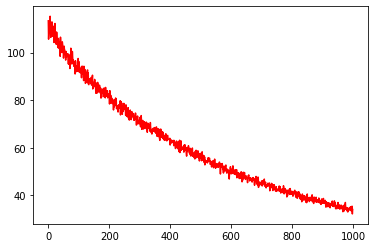

In [248]:

plt.plot(np.array(losses), 'r')

In [250]:
v1,v2,a_test = gen_rand_vecs(2, 1)

In [251]:
preprocessing = convert_to_vector_space_IUR(a_test)
tensor_test = torch.tensor(preprocessing,dtype=torch.float32)
output_test = lin(tensor_test)
M_, Z_ = _output_to_m_z(output_test)

In [252]:
M_, Z_

(tensor([[[ 0.9963,  0.0857],
          [ 0.0857, -0.9963]]], grad_fn=<CopySlices>),
 tensor([[-0.4797, -0.2473]], grad_fn=<NegBackward>))

In [5]:
# v1,v2,a = gen_rand_vecs(2, 100)

# b = a.reshape(1,100)

# #covariance matrix of the observations

# cov_mat = np.dot(b,b.T)

# Z,M = np.linalg.eig(cov_mat)

# Z_diag = np.diag(Z)

# c = np.linalg.multi_dot([M,Z_diag,M.T])

# v1_t,v2_t,a_t = gen_rand_vecs(2, 1)

# p_wonorm = np.exp(np.linalg.multi_dot([a_t,c,a_t.T]))